## SparseRegression.jl
Git: https://github.com/joshday/SparseRegression.jl



### TODO:

-  Add more extensive benchmark
-  Find out what $\omega$ parameter is

---

### Summary
Sparse regression is a package to achieve high performance regression of linear models for large dataset where coefficients often turn out to be sparse.
The main call follows the form SModel(x,y, args) where arguments include the loss, penalty, and the $\lambda$ and $\omega$ arguments.
Prediction are done through *predict(X, model)* call

The loss and penalty functions are based on the _LossFunctions_ and _PenaltyFunctions_ MLJulia core packages.

Additionally, one can use learning strategies from the _LearningStategies_ package. This allows to set parameters that are purely learning based, such as optimizers, max iterations or max items. 
More on this in the documentation.

This structure allows for one model to be used for the many linear models such as OLS, ridge, lasso etc. which all have the same underlying structure.

The library only supports univariate regression.

---
### Details

| Test        | Results           
| ------------- |:-------------:|
| Package works | yes |
| Deprecations warnings      | No      |
| Compatible with JuliaDB | If targets transformed into array |
| Contains documentation | yes, but not great |
| Simplicity | good |


---
### Usage


**SModel(x, y, args...)**

Arguments

- loss::Loss = .5 * L2DistLoss()

- penalty::Penalty = L2Penalty()

- λ::Vector{Float64} = fill(size(x, 2), .1)

- w::Union{Void, AbstractWeights} = nothing

_Note: these are interpreted from the type by the function, not from keys_

Using personalised learning strategies [(see more)](https://github.com/JuliaML/LearningStrategies.jl):

```
learn!(s, strategy(ProxGrad(s), MaxIter(25), TimeLimit(.5)))
```

**Important:** Although the library supposedly accepts integer arrays, it doesn't seem to actually work in practice

---

### Differences with Python's scikit-learn

-  Scikit-learn offers the *fit_intercept* parameter, which here is not a choice.
-  $\alpha$ parameter, $\lambda$ in this package, can only be given as a scalar in scikit, while this package allows the user to pass a vector, allowing different regularizations on features.
-  Scikit offers to normalize the data, here it is assumed the user will have done any preprocessing before using the model
-  Scikit offers to precompute the Gram matrix, which can speed up calculations
-  Scikit offers an argument named _positive_, which forces the coefficients to be positive
-  Scikit allows to give a seed for which coefficient to update, if the argument _selection_ is set to "random"
-  In scikit, all these different linear models use different functions, while this package groups them by simply allowing the user to select the loss and penalty, allowing for greater flexibility
-  Through the use of _LearningStrategies_, this package allows a lot of flexibility on the user side as to how to learn. More on these strategies can be found [here](https://github.com/JuliaML/LearningStrategies.jl)



---

### Incorporation of different models

**Ridge** 
`model = SModel(X_train,y_train, L2DistLoss(), L2Penalty());`

**Lasso**
`model = SModel(X_train,y_train, L2DistLoss(), L1Penalty());`

**Elastic-Net**
`model = SModel(X_train,y_train, L2DistLoss(), ElasticNetPenalty(α = 0.5));`

_Note: these penalties have default parameters, for more information, see the [git hub repository](https://github.com/JuliaML/PenaltyFunctions.jl)_

___

### Sample code

In [11]:
using SparseRegression;
include("load_titanic.jl");

In [12]:
X_train, y_train, X_test, y_test = load();

In [13]:
# Example using lasso regression
model = SModel(X_train,y_train, L2DistLoss(), L1Penalty());
learn!(model);
model

INFO: MaxIter(100) finished


█ SModel
  > β        : [2.52083e74 -4.01126e74 … -2.42626e75 -1.07446e73]
  > λ factor : [0.1 0.1 … 0.1 0.1]
  > Loss     : L2DistLoss
  > Penalty  : L1Penalty
  > Data
    - x : 634×8 Array{Float64,2}
    - y : 634-element Array{Int64,1}
    - w : Void

In [14]:
# Predicting new data
predict(model, X_test);

---
### (Very) Simple benchmark vs python 

(Only lasso regression is tested)

In [6]:
function compute_regression(n_points::Int64, n_dims::Int64)
    x = randn(n_points, n_dims);
    y = x * linspace(-1, 1, n_dims) + randn(n_points);
    s = SModel(x, y, L2DistLoss(), L1Penalty(), fill(1.0, size(x, 2)));

    tic();
    learn!(s);
    time = toc();
   
    return time
end

compute_regression (generic function with 1 method)

In [ ]:
IJulia.set_verbose(false)

n_points = 10_000
n_dims = [10, 100, 1000, 5000]

avg_times = []

for n_dim in n_dims
    times = []
    for i in 1:5
        time = compute_regression(n_points, n_dim);
        
        push!(times, time);
    end
    avg_times = mean(times);
    println("Average time $(avg_times) for $(n_dim) dimensions")
end

IJulia.set_verbose(true)

#### Results

| Dimensions    | Julia | Python    
| ------------- |:-----:|:-----:|
| 10 | 0.0028s | 0.023s |
| 100 | 0.0078s | 0.19s |
| 1000 | 0.61s | 2.3s|
| 5000 | 4.59s | 17s|

The code for the python's results can be found in *python_scripts.py*

#### Example varying $\beta$ in lasso regression

In [ ]:
using MLPreprocessing
using Plots
pyplot()
X_train, y_train, X_test, y_test = load();
y_train = convert(Array{Float64}, y_train)

scaler = fit(StandardScaler, X_train, obsdim=2);
X_train = MLPreprocessing.transform(X_train, scaler);

βs = []
for λ in 0.001:0.001:2.0
    model = SModel(X_train, y_train, L2DistLoss(), L1Penalty(), fill(λ, size(X_train, 2)) );
    learn!(model);
    
    push!( βs, model.β )
end

In [16]:
coefficients = zeros(length(βs), 8);
for i in 1:length(βs)
     coefficients[i,:] = convert(Array{Float64}, βs[i]);
end


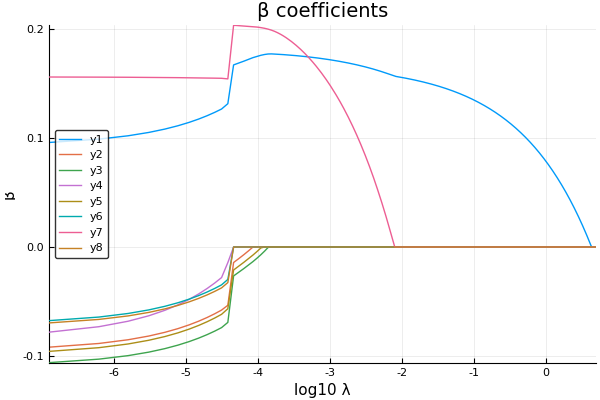

In [19]:
plot(log.(collect(0.001:0.001:2.0)), coefficients, title="β coefficients", xlabel="log10 λ", ylabel="β")